In [3]:
# imports
import math # pre 1d funkciu
import numpy as np
from keras.models import Sequential, load_model
# from keras.optimizers import *
from keras.layers import Dense, \
                         Conv2D, \
                         LeakyReLU, \
                         Dropout, \
                         Flatten, \
                         Reshape, \
                         Conv2DTranspose
from tensorflow.keras.optimizers import Adam

from keras.utils.vis_utils import plot_model
from keras import initializers, optimizers
from matplotlib import pyplot as plt
# from tensorflow_datasets.image import CelebA
from skimage.transform import resize
import random
from PIL import Image
import datetime # testing


2021-10-01 16:05:44.055746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-01 16:05:44.055851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# preprocess datasetu

dataset_path = 'dataset_download/thumbnails128x128/'
dataset_size = 70000

In [5]:
# definicie modelu
default_width = 64
default_height = 64
default_dims = 100
pixel_depth = 3 #rgb

model_type = '0_to_1_leakyReLU_tanh_x64'


def make_discriminator(n_filters=128, input_shape=(default_width, default_height, pixel_depth)):
    discriminator = Sequential()
    
    first_layer = Conv2D( # vstupne np polia su sice 3d, ale convolution sa nad nimi robi 2d
        filters=n_filters//2, 
        kernel_size=(3,3), # ^^
        strides=(2,2),
        padding='same', # iba pri rozne velkych inputs
        input_shape=input_shape
    )
    first_activation = LeakyReLU(alpha=0.2)
    
    second_layer = Conv2D(
        filters=n_filters, 
        kernel_size=(3,3),
        strides=(2,2),
        padding='same', # iba pri rozne velkych inputs
    )
    second_activation = LeakyReLU(alpha=0.2)
    
    third_layer = Conv2D(
        filters=n_filters*2, 
        kernel_size=(3,3),
        strides=(2,2),
        padding='same', # iba pri rozne velkych inputs
    )
    third_activation = LeakyReLU(alpha=0.2)
    
    flatten = Flatten()
    dropout = Dropout(0.4)
    output_dense = Dense(
        units=1, # real/fake klasifikacia
        activation='sigmoid'
    )
    
    discriminator.add(first_layer)
    discriminator.add(first_activation)
    discriminator.add(second_layer)
    discriminator.add(second_activation)
    discriminator.add(third_layer)
    discriminator.add(third_activation)
    
    discriminator.add(flatten)
    discriminator.add(dropout)
    discriminator.add(output_dense)
    
    discriminator.summary()
    adam = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy']) # metrics kvoli evaluation
    return discriminator
   
    
def make_generator(n_dim=100, n_paralell_samples=256):
    generator = Sequential()
    
    first_layer = Dense(
        units=(default_height // 8) * (default_width // 8) * n_paralell_samples,
        input_dim=n_dim,
        # activation='linear'
    )
    first_activation = LeakyReLU(alpha=0.2)
    reshape = Reshape((default_height // 8, default_width // 8, n_paralell_samples))
    
    first_upsample = Conv2DTranspose( # alternativne UpSample2D + Conv2D, zvacsenie a domyslenie, toto ich spaja do 1
        filters=n_paralell_samples // 2,
        kernel_size=(4,4), # idealne nasobok strides, inak moze nastat sachovnicovy vzor v convolution
        strides=(2,2),
        # activation='linear',
        padding='same',
    )
    first_upsample_activation = LeakyReLU(alpha=0.2)
    
    second_upsample = Conv2DTranspose( # alternativne UpSample2D + Conv2D, zvacsenie a domyslenie, toto ich spaja do 1
        filters=n_paralell_samples // 2, # vygeneruje RGB values
        kernel_size=(4,4), # idealne nasobok strides, inak moze nastat sachovnicovy vzor v convolution
        strides=(2,2),
        # activation='linear',
        padding='same',
    )
    second_upsample_activation = LeakyReLU(alpha=0.2)
    
    third_upsample = Conv2DTranspose( # alternativne UpSample2D + Conv2D, zvacsenie a domyslenie, toto ich spaja do 1
        filters=n_paralell_samples // 2, # vygeneruje RGB values
        kernel_size=(4,4), # idealne nasobok strides, inak moze nastat sachovnicovy vzor v convolution
        strides=(2,2),
        # activation='linear',
        padding='same',
    )
    third_upsample_activation = LeakyReLU(alpha=0.2)
    
    output_layer = Conv2D(
        filters=pixel_depth, #rgb info
        kernel_size=(3,3),
        activation='tanh', # specialna akt. funk. pre rgb
        padding='same'
    )
    
    generator.add(first_layer)
    generator.add(first_activation)
    generator.add(reshape)
    generator.add(first_upsample)
    generator.add(first_upsample_activation)
    generator.add(second_upsample)
    generator.add(second_upsample_activation)
    generator.add(third_upsample)
    generator.add(third_upsample_activation)
    generator.add(output_layer)
    
    return generator
    
    
def make_gan_model(generator, discriminator): #spoločný model cez ktorý sa môže generátor trénovať
    discriminator.trainable = False
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    model.layers[0]._name = 'Generator'
    model.layers[1]._name = 'Discriminator'
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=adam)
    return model
    
    
    


In [8]:
# definicie funkcii

real_sample_dict = {}

def rgb_to_float(rgb_value):
    zero_to_one = rgb_value / 256.0
    # normalized = (zero_to_one - 0.5) * 2
    return zero_to_one

def float_to_rgb(float_value):
    # converted_float = (float_value / 2) + 0.5
    rgb_value = (float_value * 256)
    rgb_value = np.where(rgb_value > 255, 255, rgb_value)
    rgb_value = np.where(rgb_value < 0, 0, rgb_value).astype('uint8')
    return rgb_value

def generate_real_samples(n, i_min=0, i_max=dataset_size):
    picked_sample_list = list()
    for i_image in range(n):
        chosen_sample = random.choice(range(i_min,i_max))
        #print(i_image, 'chose image', chosen_sample)
        
        if chosen_sample not in real_sample_dict:
            chosen_folder = chosen_sample - (chosen_sample % 1000)
            
            folder_string = str(chosen_folder)
            image_string = str(chosen_sample)
            folder_string = folder_string.rjust(5,'0') #padding
            image_string = image_string.rjust(5,'0') #padding   
            
            full_path = dataset_path + folder_string + '/' + image_string + '.png'
            
            with Image.open(full_path) as image:
                image_array = np.array(image)
            image_array = resize(image_array, (default_height, default_width))
            
            real_sample_dict[chosen_sample] = image_array
            
        else:
            image_array = real_sample_dict[chosen_sample]
        picked_sample_list.append(image_array)
    
    # po nacitani n-vzoriek:
    X = np.array(picked_sample_list) #.reshape(n, 1)
    y = np.ones((n, 1))
    return X, y   
    # print(image_array)

def generate_noise_samples(n):
    samples = list()
    for i_sample in range(n):
        random_array = np.random.randint(0, high=255, size=default_height * default_width * pixel_depth)
        random_array = random_array.reshape(default_height, default_width, pixel_depth)
        samples.append(random_array)
    X = np.array(samples) #.reshape(n, (default_height, default_width, pixel_depth))
    y = np.zeros((n, 1))
    return X,y

def random_latent_points(n_dim, n):
    latent_vectors = np.random.randn(n_dim * n) # n čísel z gauss. distrib.
    latent_vectors = latent_vectors.reshape(n, n_dim)
    return latent_vectors

def generate_fake_samples(generator, x_input, n_dim, n): # [-1,1]
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

def train_discriminator_noise(model, n_iter=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(half_batch)
        X_real = rgb_to_float(X_real.astype('float32'))
        model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_noise_samples(half_batch)
        X_fake = rgb_to_float(X_fake.astype('float32'))
        model.train_on_batch(X_fake, y_fake)
        
        _, accuracy_real = model.evaluate(X_real, y_real, verbose=0)
        _, accuracy_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        print(i, '\nReal', accuracy_real, '\nFake', accuracy_fake)

p_dims = 100
p_n = 100
predetermined_inputs = np.random.randn(p_dims * p_n) # n vektorov z gauss. distrib.
predetermined_inputs = predetermined_inputs.reshape(p_n, p_dims)


    
    
def eval_performance(gan_model, generator, discriminator, losses, metadata_list, init_time,
                     n_dim, i_epoch, n_epochs, n=25, n_plot=10, plot_size=9):
    
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    input_points = random_latent_points(n_dim, n)
    x_fake, y_fake = generate_fake_samples(generator, input_points, n_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    print(
        f'''[GAN training] Epoch {i_epoch}/{n_epochs}:
        Acc. real: {acc_real}
        Acc. fake: {acc_fake}'''
          )
    
    time_taken = datetime.datetime.now() - init_time
    
    eval_string = f'''[Epoch {i_epoch}/{n_epochs}] 
    Time since start: {time_taken}
    Disc. loss real: {losses[0]}
    Disc. loss fake: {losses[1]}
    Gen. loss: {losses[2]}
    Acc. real: {acc_real}
    Acc. fake: {acc_fake} (of {n} samples)
    '''
    
    with open('epoch_metadata.txt', 'a') as metadata_file:
        metadata_file.write(eval_string)
    print(eval_string)
    
    metadata_list.append(
        [
        time_taken.seconds / 3600, # float hodnota kolko hodin od startu
        losses[0],
        losses[1],
        losses[2],
        acc_real,
        acc_fake
        ]
    )
    
    if i_epoch % n_plot == 0:
        # n_factor = math.sqrt(n)
        fig = generate_and_plot(generator, n_dim, plot_size)
        padding_size = len(str(n_epochs-1))
        filename = f"{model_type}/outputs/output_epoch_{str(i_epoch).rjust(padding_size,'0')}.png"
        fig.savefig(filename)
        plt.show(fig)
        plt.close(fig)
        #input_points = random_latent_points(n_dim, n_factor * n_factor)
        #x_plt, _ = generate_fake_samples(generator, predetermined_inputs, n_dim, n_factor * n_factor)
        #padding_size = len(str(n_epochs-1))
        #fig = plt.figure(figsize=(n_factor*1.5, n_factor*1.5))
        #plt.text(0.5,-0.15,
        #f'''[Epoch {i_epoch}/{n_epochs}] Time since start: {datetime.datetime.now() - init_time}
        #Disc. loss real: {round(losses[0], 4)}, Disc. loss fake: {round(losses[1], 4)}, Gen. loss: {round(losses[2], 4)}
        #Acc. real: {round(acc_real, 4)}, Acc. fake: {round(acc_fake, 4)} (of {n} samples)
        #''',
        #         horizontalalignment='center')
        #
        #fig.subplots_adjust(wspace=1/default_width, 
        #                    hspace=1/default_height
        #                    )
        #for i in range(n_factor * n_factor):
        #    if i == 0:
        #        print(x_plt[i, default_height//2, default_width//2], '\n', ((x_plt[i, default_height//2, default_width//2]/2 + 0.5)*256).astype('int'))
        #    
        #    # define subplot
        #    ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        #    plt.axis('off')
        #    ax.imshow(float_to_rgb(x_plt)[i], interpolation='nearest')
        #
        #filename = f"{model_type}/outputs/generator_epoch_{str(i_epoch).rjust(padding_size,'0')}.png"
        #fig.savefig(filename)
        #plt.show()
        #plt.close(fig)
        
        
def train_gan(gan_model, generator, discriminator, metadata_list,
              n_dim=100, start_epoch=0, n_epochs=100000, n_batch=128, n_eval=2000, eval_samples=64, n_plot=10, plot_size=9):
    # diskriminator updatujeme so vstupmi v pocte n_batch, pol. real, pol. fake
    half_batch = n_batch // 2
    
    batches = dataset_size // n_batch
    
    init_time = datetime.datetime.now()
    
    for i in range(n_epochs):
        
        # vstup a target pre diskriminator
        x_real, y_real = generate_real_samples(half_batch)
        input_points = random_latent_points(n_dim, half_batch)
        x_fake, y_fake = generate_fake_samples(generator, input_points, n_dim, half_batch)
        
        d_loss1, _ = discriminator.train_on_batch(x_real, y_real)
        d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
        
        # vstup a target pre generator
        x_gan = random_latent_points(n_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        if i % n_eval == 0:
            losses = (d_loss1, d_loss2, g_loss)
            print('Timestamp:', datetime.datetime.now())
            print(f"d_loss1 {d_loss1}\nd_loss2 {d_loss2}\ng_loss  {g_loss}")
            eval_performance(gan_model, generator, discriminator, losses, init_time,
                             n_dim, i, n_epochs, eval_samples, n_plot, plot_size=plot_size)
            
        print("Epoch", i)

            
def show_dataset():
    x_plt, _ = generate_real_samples(16)
    n_factor = 3 # 4x4
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(n_factor * n_factor): # ZMEN ABY NAMIESTO 4,5 BOLI FACTORS
        # define subplot
        ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        plt.axis('off')
        ax.imshow(x_plt[i], interpolation='nearest')
    plt.show()
    plt.close(fig)
    
def generate_and_plot(generator, n_dim, n):
    n_factor = int(math.sqrt(n))
    input_points = random_latent_points(n_dim, n)
    x_plt, _ = generate_fake_samples(generator, input_points, n_dim, n)
    
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(frameon=False, figsize=((n_factor*default_width)*px, (n_factor*default_height)*px))
    
    for i in range(n_factor * n_factor): # ZMEN ABY NAMIESTO 4,5 BOLI FACTORS
        # define subplot
        ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        ax.axis('off')
        ax.imshow(float_to_rgb(x_plt)[i], interpolation='nearest')
    plt.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    return fig
        

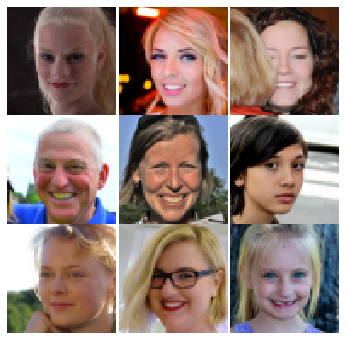

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [9]:
show_dataset() # realne vzorky z datasetu v aktualne zvolenom rozliseni

#X,y = generate_noise_samples(10)
discriminator = make_discriminator()
generator = make_generator()
gan = make_gan_model(generator, discriminator)

In [11]:
from_epoch = 0
to_epoch = 1000

metadata_list = []

a = datetime.datetime.now()

train_gan(gan, generator, discriminator, metadata_list,
          n_dim=100, start_epoch=from_epoch, n_epochs=to_epoch, 
          n_batch=128, n_eval=10, eval_samples=256, n_plot=100, plot_size=5)

b = datetime.datetime.now()
print("Time taken: ", b - a)

fig = plt.figure(figsize=(8, 6))
fig.plot(metadata_list[0, :], metadata_list[1, :])
fig.plot(metadata_list[0, :], metadata_list[2, :])
fig.plot(metadata_list[0, :], metadata_list[3, :])
fig.plot(metadata_list[0, :], metadata_list[4, :])
fig.plot(metadata_list[0, :], metadata_list[5, :])

gan.save(f"{model_type}/saves/gan_{to_epoch}")
generator.save(f"{model_type}/saves/generator_{to_epoch}")
discriminator.save(f"{model_type}/saves/discriminator_{to_epoch}")

Timestamp: 2021-10-01 16:14:25.667662
d_loss1 0.5727052688598633
d_loss2 0.697526216506958
g_loss  0.6895501613616943


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer Generator is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape (None, 0)


In [ ]:
input_points = random_latent_points(100, 10)
X,y = generate_fake_samples(generator, input_points, 100, 10)
for i_sample in float_to_rgb(X):
    plt.axis('off')
    plt.imshow(i_sample)
    plt.show()
    plt.close()

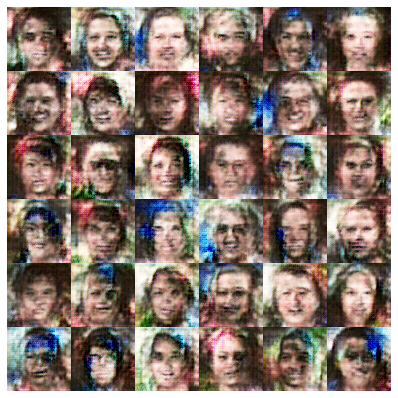

In [41]:
generate_and_plot(generator, 100, 36)

In [8]:
gan.save(f"saves/gan_x64")
generator.save(f"saves/generator_x64")
discriminator.save(f"saves/discriminator_x64")

INFO:tensorflow:Assets written to: saves/gan_x64/assets
INFO:tensorflow:Assets written to: saves/generator_x64/assets
INFO:tensorflow:Assets written to: saves/discriminator_x64/assets


In [6]:
gan = load_model(f"saves/gan_x64")
generator = load_model(f"saves/generator_x64")
discriminator = load_model(f"saves/discriminator_x64")

2021-09-28 14:23:05.827222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-28 14:23:05.827282: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-28 14:23:05.827312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (646f13c55343): /proc/driver/nvidia/version does not exist
2021-09-28 14:23:05.827510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
